In [1]:
import pandas as pd
import numpy as np
import ast
from shapely.geometry import LineString, MultiLineString
from datetime import timedelta

## Traffic jams - odstranění duplicit, groupBy

In [2]:
trafficDelaysDf = pd.read_csv('trafficDelaysDateStreets.csv')

seřazení hodnot podle ulice, level, length, datumCas

In [3]:
trafficDelaysDf=trafficDelaysDf.sort_values(by = ['street','level','length','datumCas'], axis = 0)

In [4]:
trafficDelaysDf.head()

,uuid,pubMillis,level,delay,speed,speedKMH,length,street,city,blockingAlertUuid,objectid,datumCas,datum,weekdays,hours,quarters,minutes,coordType,coordinates
54566,1758204495,2020/08/28 13:04:34.938+00,2,81,8,28.8,1406,00215,Brno,NaN,54567,2020-08-28 15:04:34,2020-08-28,Friday,15,0,4,LineString,"[[16.396626, 49.207064], [16.396653, 49.206098..."
54649,1908368646,2020/08/28 13:41:14.164+00,2,81,8,28.8,1406,00215,Brno,NaN,54650,2020-08-28 15:41:14,2020-08-28,Friday,15,30,41,LineString,"[[16.396626, 49.207064], [16.396653, 49.206098..."
31249,1514921112,2020/08/09 20:00:56.254+00,3,238,4,14.4,1197,00215,Brno,NaN,31250,2020-08-09 22:00:56,2020-08-09,Sunday,22,0,0,LineString,"[[16.396125, 49.209505], [16.39628, 49.208651]..."
21490,609394922,2020/07/30 08:33:42.769+00,3,106,2,7.2,254,00219,Brno,NaN,21491,2020-07-30 10:33:42,2020-07-30,Thursday,10,30,33,LineString,"[[16.605032, 49.104682], [16.605143, 49.105088..."
28398,1188847118,2020/08/05 18:22:13.048+00,3,117,5,18.0,1116,00219,Popovice,NaN,28399,2020-08-05 20:22:13,2020-08-05,Wednesday,20,15,22,LineString,"[[16.607265, 49.10312], [16.61084, 49.104611],..."


In [5]:
trafficDelaysDf=trafficDelaysDf.reset_index()
trafficDelaysDf=trafficDelaysDf.drop(['index'], axis = 1)

serie T/F a tabulka duplikátů podle level, street, datum

In [6]:
DuplSerie = trafficDelaysDf.duplicated(subset = ['level', 'street','datum'])
trafficDelaysDfDupl = trafficDelaysDf[trafficDelaysDf.duplicated(subset = ['level', 'street','datum'])]
len(trafficDelaysDfDupl)

84021

převod sloupce coordinates na seznam čísel (místo str)

In [7]:
def geotype(coordserie):
    geocoord = ast.literal_eval(coordserie)    
    return geocoord

In [8]:
trafficDelaysDf['coordinates'] = trafficDelaysDf['coordinates'].apply(geotype)

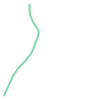

In [9]:
LineString(trafficDelaysDf['coordinates'][1])

převod sloupce coordinates na MultiLineString a LineString - nový sloupec geo

In [9]:
geocoord = []
for i in trafficDelaysDf.index:
    if trafficDelaysDf['coordType'][i] == 'MultiLineString':
        geocoord.append(MultiLineString(trafficDelaysDf['coordinates'][i]))
    else:
        geocoord.append(LineString(trafficDelaysDf['coordinates'][i]))

In [10]:
trafficDelaysDf['geo']= geocoord

In [12]:
trafficDelaysDf['geo'][2].intersects(trafficDelaysDf['geo'][3])

False

odstranění duplikátů (podle ulice,levelu, času pokud je rozdíl < 15min a souřadnic, pokud se překrývají)

In [11]:
trafficDelaysDf1=trafficDelaysDf.copy()

In [12]:
trafficDelaysDf['datumCas'] = pd.to_datetime(trafficDelaysDf['datumCas'])

In [13]:
for i in range(1,len(trafficDelaysDf1)):
    if (DuplSerie[i]) & (trafficDelaysDf['datumCas'][i]-trafficDelaysDf['datumCas'][i-1]< timedelta(minutes = 15))&(trafficDelaysDf['geo'][i].intersects(trafficDelaysDf['geo'][i-1])):
        trafficDelaysDf1=trafficDelaysDf1.drop([i])
        i = i-1

In [14]:
len(trafficDelaysDf1)

102361

In [15]:
trafficDelaysDf1.head()

,uuid,pubMillis,level,delay,speed,speedKMH,length,street,city,blockingAlertUuid,objectid,datumCas,datum,weekdays,hours,quarters,minutes,coordType,coordinates,geo
0,1758204495,2020/08/28 13:04:34.938+00,2,81,8,28.8,1406,00215,Brno,NaN,54567,2020-08-28 15:04:34,2020-08-28,Friday,15,0,4,LineString,"[[16.396626, 49.207064], [16.396653, 49.206098...","LINESTRING (16.396626 49.207064, 16.396653 49...."
1,1908368646,2020/08/28 13:41:14.164+00,2,81,8,28.8,1406,00215,Brno,NaN,54650,2020-08-28 15:41:14,2020-08-28,Friday,15,30,41,LineString,"[[16.396626, 49.207064], [16.396653, 49.206098...","LINESTRING (16.396626 49.207064, 16.396653 49...."
2,1514921112,2020/08/09 20:00:56.254+00,3,238,4,14.4,1197,00215,Brno,NaN,31250,2020-08-09 22:00:56,2020-08-09,Sunday,22,0,0,LineString,"[[16.396125, 49.209505], [16.39628, 49.208651]...","LINESTRING (16.396125 49.209505, 16.39628 49.2..."
3,609394922,2020/07/30 08:33:42.769+00,3,106,2,7.2,254,00219,Brno,NaN,21491,2020-07-30 10:33:42,2020-07-30,Thursday,10,30,33,LineString,"[[16.605032, 49.104682], [16.605143, 49.105088...","LINESTRING (16.605032 49.104682, 16.605143 49...."
4,1188847118,2020/08/05 18:22:13.048+00,3,117,5,18.0,1116,00219,Popovice,NaN,28399,2020-08-05 20:22:13,2020-08-05,Wednesday,20,15,22,LineString,"[[16.607265, 49.10312], [16.61084, 49.104611],...","LINESTRING (16.607265 49.10312, 16.61084 49.10..."


In [16]:
trafficDelaysDf1.to_csv('trafficJamsFinal3.csv', encoding = 'utf-8', index = False)

In [17]:
trafficDelaysDf1=trafficDelaysDf1.drop(['coordType','coordinates','geo'], axis = 1)# verze bez souřadnic

In [18]:
trafficDelaysDf1.to_csv('trafficJamsFinal3NoCoord.csv', encoding = 'utf-8', index = False)

GROUP BY - vytvoření souboru s počty záznamů podle dnů a hodin

In [19]:
jamsGroupDf = trafficDelaysDf1.copy()

In [ ]:
#jamsGroupDf = pd.read_csv('trafficJamsFinal3NoCoord.csv', encoding = 'utf-8')

In [20]:
#jamsGroupDf['datum'] = pd.to_datetime(jamsGroupDf['datum']).apply(date) ...při načtení znova ze souboru
jamsGroupDf = jamsGroupDf.rename(columns={'hours':'hour'})

In [21]:
jamsGroupDf = jamsGroupDf.sort_values(by = 'datumCas').groupby(['datum','hour'])['uuid'].count()

In [22]:
jamsGroupDf

datum       hour
2020-07-13  4       142
            5         4
            6         1
            7         1
            9         1
                   ... 
2020-10-13  5         5
2020-10-14  4        37
            9        21
            18        3
            19        7
Name: uuid, Length: 2060, dtype: int64

In [23]:
jamsGroupDf.to_csv('jamsGroupDf1.csv', encoding = 'UTF-8')